# human SKM MF (single-cell)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import collections
import scanpy as sc
import scvi

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

from datetime import date
today = str(date.today())

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')

# %cd /nfs/team205/vk8/processed_data/muscle/data_v3

results = './write/'

Global seed set to 0
/home/LiuTL/anaconda3/envs/scanpy/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/LiuTL/anaconda3/envs/scanpy/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
general_mrkrs = [ 'MYH7', 'TNNT1', 'TNNT3', 'MYH1', 'MYH2', "CKM", "MB", # Myofibers
           'PAX7', 'DLK1', # MuSCs
           'PDGFRA', 'DCN', 'ANGPTL7', 'OSR2', 'NGFR', 'SLC22A3','ITGA6', # Fibroblasts
           'FMOD', 'TNMD' ,  'MKX', # Tenocytes
 'MPZ', 'MBP',  # Schwann cells
'CDH2', 'L1CAM', # SCG
'MSLN', 'ITLN1', # mesothelium
"ADIPOQ", "PLIN1", # adipocytes
'PTPRC', 'CD3D', 'IL7R', # T cells
'NKG7', 'PRF1', #NK cells
'CD79A', "TCL1A",  # B cells
'MZB1', 'JCHAIN', # B plasma 
"CD14", "FCGR3A",'S100A8', 'S100A12', # Mono
"CD163", "C1QA", # Macrop
"XCR1", "CLEC9A", # cDC1 "CADM1",
"CD1C", "CLEC10A", "CCR7", # cDC2
'LILRA4', 'IL3RA', "IRF7",  # pDC 
'FCGR3B', 'CSF3R', 'SORL1',  # Neutrophils
'EPX', 'PRG2', # Eosinophils 'CLC'
'TPSB2', 'MS4A2', # Mast cells
'PECAM1', 'HEY1','CLU', # art EC
'CA4', 'LPL', # capEC
'ACKR1', 'SELE', # venEC
'LYVE1', 'TFF3',  # lymphEC
'RGS5','ABCC9', # pericytes           
'MYH11', 'ACTA2', # SMC
'HBA1', #RBC
    ]

In [3]:
adata_sc = sc.read(f'{results}/ICM_scell_dbrm_scvi_v2_2023-03-06.h5ad')

In [4]:
list1 = adata_sc[adata_sc.obs['coarse_majority_voting']=='MF_typeI(fg)'].obs.index
list2 = adata_sc[adata_sc.obs['coarse_majority_voting']=='MF_typeII(fg)'].obs.index
list3 = adata_sc[adata_sc.obs['coarse_majority_voting']=='Specialised_MF_populations'].obs.index

list_all = list1.append(list2).append(list3)

In [5]:
adata = adata_sc[list_all]

In [6]:
adata

View of AnnData object with n_obs × n_vars = 12896 × 33538
    obs: 'SampleID', 'barcode', 'concat_sample_no', 'DonorID', 'Sex', 'Age', 'Species', 'Operator', 'Sample', '10X_version', 'n_counts', 'n_counts_raw', 'percent_soup', 'n_counts_spliced', 'n_counts_unspliced', 'percent_spliced', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'Age_group', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'S_score', 'G2M_score', 'phase', 'is_doublet_scrub', 'annotation_level0', 'annotation_level1', 'annotation_level2', 'sample_type', 'update_status', 'putative_doublet_scvi1', '_scvi_batch', '_scvi_labels', 'leiden', 'coarse_predicted_labels', 'coarse_over_clustering', 'coarse_majority_voting', 'coarse_conf_score', 'fine_predicted_labels', 'fine_over_clustering', 'fine_majority_voting', 'fine_conf_score', 'fine2_predicted_labels', 'fine2_over_clustering', 'fine2_majority_voting', 'fine2_conf_score'
    var: 'ENSEMBL', 'SYMBOL', 'n_counts', 'n_cells', 'mean', 'std'
   

In [8]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # keep full dimension safe

In [9]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=10000, layer="counts",batch_key='Age_group', subset = True)

scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key='SampleID',
                              categorical_covariate_keys=["DonorID", "Sex", "10X_version"],
                              continuous_covariate_keys=['percent_mito'])

vae = scvi.model.SCVI(adata,n_hidden=128, n_latent=30, n_layers=2)
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)
sc.tl.umap(adata)

/home/LiuTL/anaconda3/envs/scanpy/lib/python3.8/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/home/LiuTL/anaconda3/envs/scanpy/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/LiuTL/anaconda3/envs/scanpy/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 400/400: 100%|██████████| 400/400 [36:58<00:00,  6.05s/it, loss=1.4e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [36:58<00:00,  5.55s/it, loss=1.4e+03, v_num=1]


In [10]:
adata

AnnData object with n_obs × n_vars = 12896 × 10000
    obs: 'SampleID', 'barcode', 'concat_sample_no', 'DonorID', 'Sex', 'Age', 'Species', 'Operator', 'Sample', '10X_version', 'n_counts', 'n_counts_raw', 'percent_soup', 'n_counts_spliced', 'n_counts_unspliced', 'percent_spliced', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'Age_group', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'S_score', 'G2M_score', 'phase', 'is_doublet_scrub', 'annotation_level0', 'annotation_level1', 'annotation_level2', 'sample_type', 'update_status', 'putative_doublet_scvi1', '_scvi_batch', '_scvi_labels', 'leiden', 'coarse_predicted_labels', 'coarse_over_clustering', 'coarse_majority_voting', 'coarse_conf_score', 'fine_predicted_labels', 'fine_over_clustering', 'fine_majority_voting', 'fine_conf_score', 'fine2_predicted_labels', 'fine2_over_clustering', 'fine2_majority_voting', 'fine2_conf_score'
    var: 'ENSEMBL', 'SYMBOL', 'n_counts', 'n_cells', 'mean', 'std', 'highly_va

/home/LiuTL/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


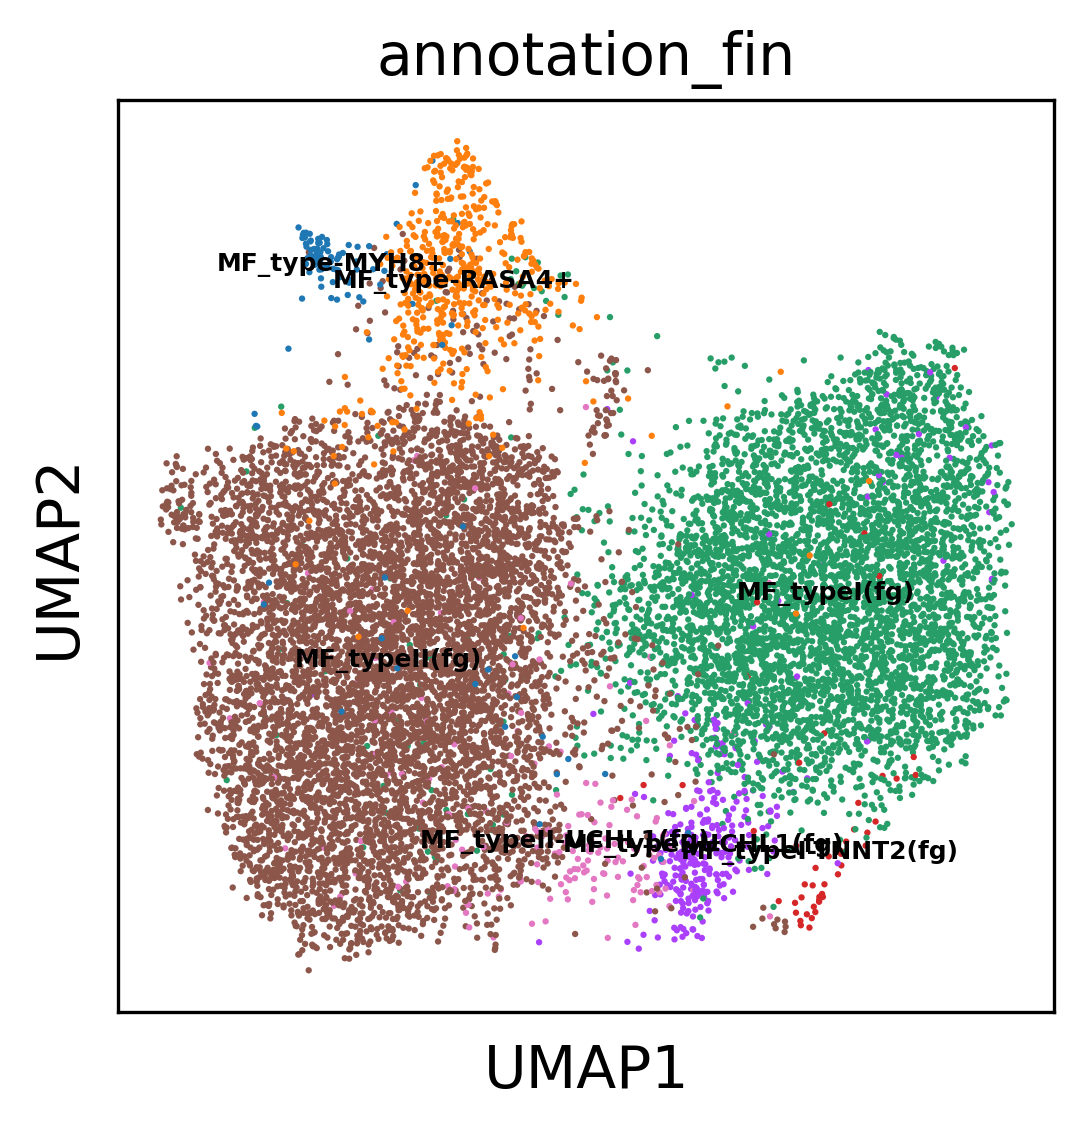

In [4]:
sc.pl.umap(adata, color = ['annotation_fin',],legend_loc='on data',legend_fontsize=6 )

In [7]:
adata_myh8 = adata[adata.obs['annotation_fin']=='MF_type-MYH8+']

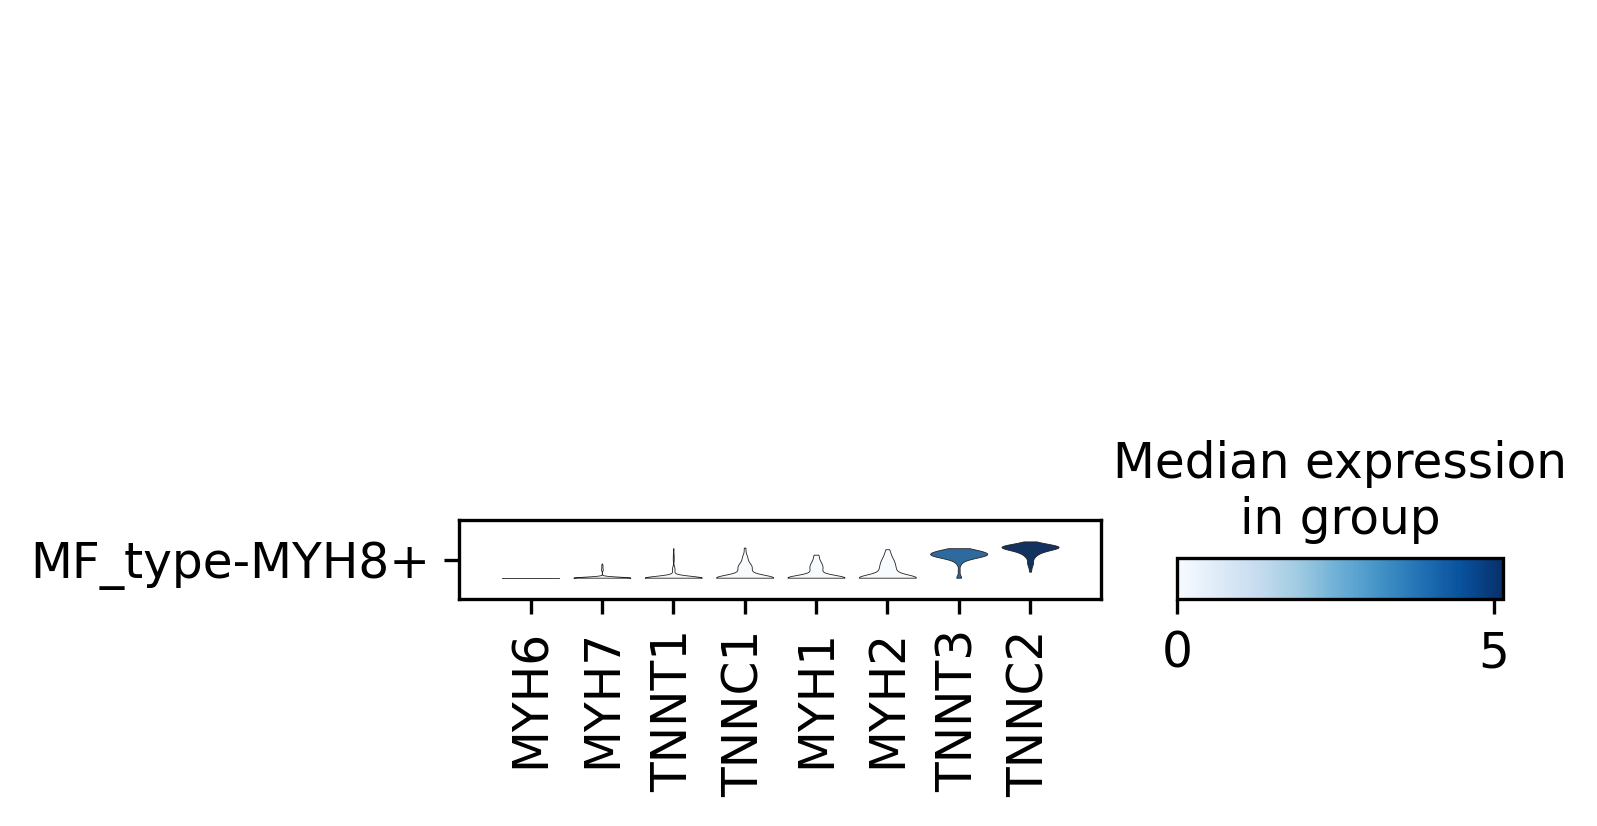

In [45]:
sc.pl.stacked_violin(adata_myh8,['MYH6','MYH7','TNNT1','TNNC1','MYH1','MYH2','TNNT3','TNNC2',],groupby='annotation_fin',
                    save='ICM_MF_scvi_myh8.pdf')`